# Computing FPCA components of UV-Vis spectra
In this notebook, we are going to load the UV-Vis spectroscopy data of seven peptides studied in this paper and perform a functional principle component analysis essentially to reproduce Figure 3 from the paper.

The code involves few extra components in comparision to the standard multi-variate PCA which we would highlight when appropritate

First, install the python package `fdasrsf` by running this cell as is

In [ ]:
!pip install --quiet fdasrsf==2.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Next step is to load necessary python packages

In [ ]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import pdb

plt.rcParams.update({"text.usetex": False,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

import sys, os
data_dir = './data/peptides_uvvis/'
peptides = ['MZ2', 'MZ2R', 'Z2', 'PZ2', 'Z2M6I', 'Z2M246I', 'AG3']

import fdasrsf as FDA

### Helper function to read UV-Vis data into python

We provide a utility data reader function for UV-Vis data which we have loaded above.

We will use this custom class UVVis to load and prepare the data for FPCA.

In [ ]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

SI = pd.read_csv(data_dir + '/4x4x4_SI.csv', index_col=0)
peptides = SI['peptide_name'].value_counts().index.to_list()
print(peptides)

class UVVis:
    def __init__(self, name, scale=True):
        self.name = name
        self.df = SI[SI['peptide_name']==self.name]
        self.df.reset_index(drop=True, inplace=True)
        self.wav = self.wavelength()
        self.wavindx = np.logical_and(self.wav>=400, self.wav<=900)
        self.wav = self.wav[self.wavindx]
        self.dspace = self.get_dspace()
        self.scale = scale
        self._X()

    def _X(self):
        X = []
        for row, item in self.df.iterrows():
            uid = item['UID']
            data = pd.read_csv(data_dir+'/%s.txt'%uid, sep=',')
            x = data['subtracted_absorbance'][self.wavindx]
            if self.scale:
                x = minmax_scale(x)
            X.append(x)

        self.X = np.asarray(X)

    def __getitem__(self,i):
        return self.X[i,:], self.dspace[i,:]

    def __len__(self):
        return len(self.X)

    def shape(self):
        return self.X.shape

    def wavelength(self):
        uid = self.df.loc[0,'UID']
        data = pd.read_csv(data_dir+'/%s.txt'%uid, sep=',')
        wav = data['wavelength'].to_numpy()

        return wav

    def get_dspace(self):
        coords = self.df.loc[:,['peptide','HAuCl4','hepes']].to_numpy()
        scaled = []
        self.encoders = {}
        for i,col in enumerate(coords.T):
            le = LabelEncoder()
            scaled.append(le.fit_transform(col))
            self.encoders[i] = le

        scaled_coords = np.asarray(scaled).T

        return scaled_coords

    def level_to_conc(self, c):
        conc = []
        for i,ci in enumerate(c):
            conc.append(self.encoders[i].inverse_transform([ci]))

        return conc

    def savez(self,fname=None):
        if fname is None:
            fname = '../data/%s.npz'%self.name
        np.savez(fname,self.X,self.dspace()[0],self.wav)


['MZ2', 'MZ2R', 'Z2', 'PZ2', 'Z2M6I', 'Z2M246I', 'AG3']


### Data extraction and Functional PCA

The package fdasrsf which we use to compute FPCA components, requires the data to be provided in a matrix form as shown below

In [ ]:
X = []
for i, peptide in enumerate(peptides):
    data = UVVis(peptide, scale=False)
    Xp = data.X
    X.append(Xp)
X = np.vstack(X) # intensity values of UV-Vis spectra along the rows
grid_points = data.wav # wavelength sampling, same for all the spectra

print('Data matrix shape: ', X.shape)
print('Grid points shape: ', grid_points.shape)

Data matrix shape:  (448, 101)
Grid points shape:  (101,)


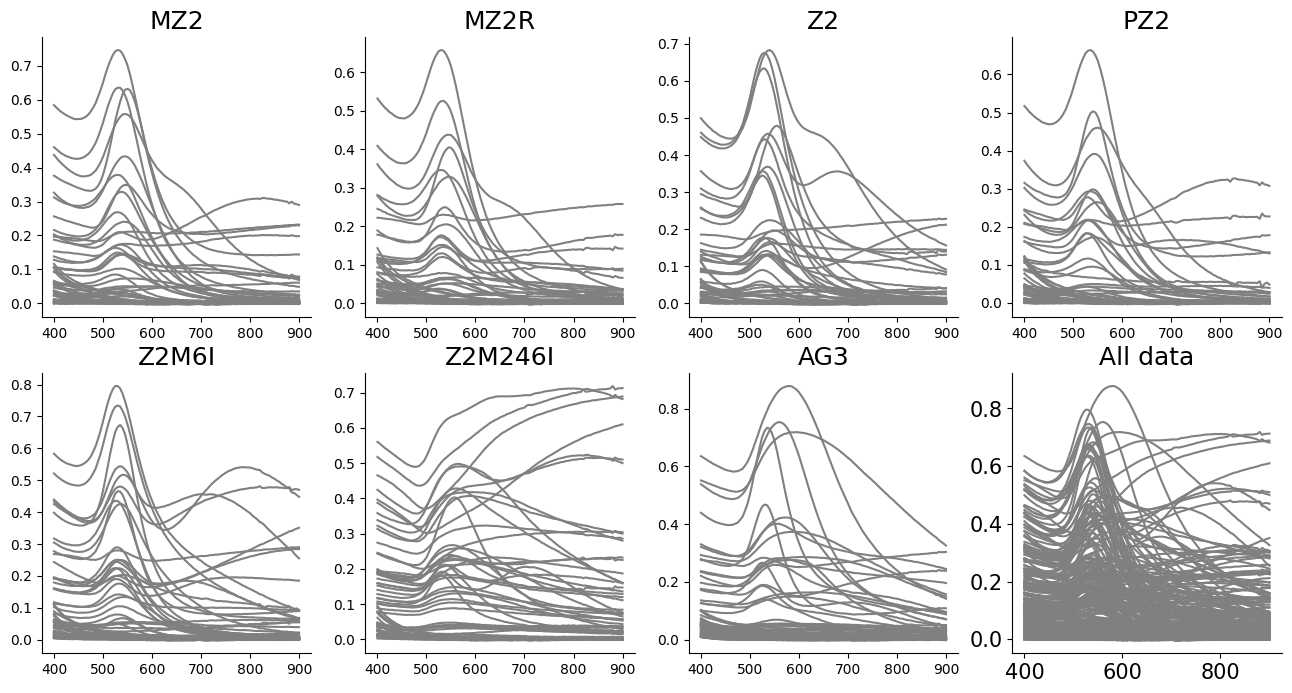

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(4*4, 2*4))
axs = axs.flatten()
for i, peptide in enumerate(peptides):
    data = UVVis(peptide, scale=False)
    for xi in data.X:
      axs[i].plot(data.wav, xi, color='grey')
      axs[-1].plot(data.wav, xi, color='grey')
    # We change the fontsize of minor ticks label
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].tick_params(axis='both', which='minor', labelsize=8)
    # plt.savefig('%s.png'%peptide, dpi=600)
    axs[i].set_title(peptide)

axs[-1].set_title("All data")
plt.show()


## Multi-varatie PCA

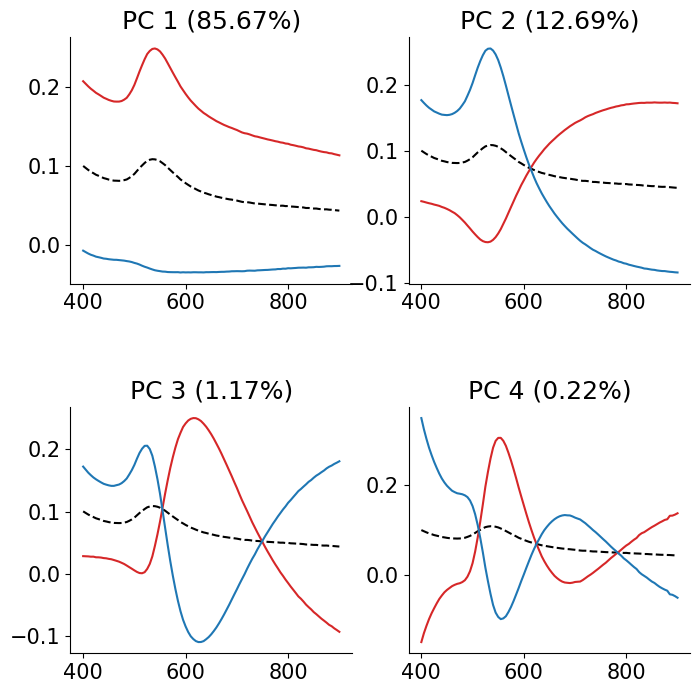

In [ ]:
from sklearn.decomposition import PCA

def pca(S):
  pca = PCA(n_components=10)
  pca.fit(S)

  return pca

mvpca = pca(np.asarray(X))

fig, axs = plt.subplots(2,2, figsize=(2*4, 2*4))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
axs = axs.flatten()
for i in range(4):
  axs[i].plot(grid_points, mvpca.mean_, ls = "--", color = "k")
  pos_coef = np.zeros(10)
  pos_coef[i]= 1.0
  neg_coef =  np.zeros(10)
  neg_coef[i] = -1.0
  axs[i].plot(grid_points, mvpca.inverse_transform(pos_coef), color="tab:red")
  axs[i].plot(grid_points, mvpca.inverse_transform(neg_coef), color="tab:blue")
  axs[i].set_title(r'PC %d (%.2f'%(i+1, mvpca.explained_variance_ratio_[i]*100)+r'%)')

plt.show()



The above only gives us partially correct information : There's formation and non formation of peaks and intensity increase at higher wavelength. These two are indeed the major variations we observe but the explained variance is highly skewed towards the existence of a peak. This is not quite true.

More importantly, this model does not inform us about any peak shifts that exists. We will see next if FPCA approach reveals anything different than this as it is better equipped to model the variations on x-axis

In [ ]:
def fpca(S, t):
  # create an object to represent the functional data
  obj = FDA.fdawarp(S,t)
  # align the functions using the SRSF framework (see http://arxiv.org/abs/1212.1791)
  obj.srsf_align(parallel=True, MaxItr=50)

  # Computing the join FPCA components
  jpca = FDA.fdajpca(obj)
  jpca.calc_fpca(no=10)

  return jpca

jpca = fpca(np.asarray(X).T,grid_points)

Initializing...
Compute Karcher Mean of 448 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
updating step: r=21
updating step: r=22
updating step: r=23
updating step: r=24
updating step: r=25
updating step: r=26
updating step: r=27
updating step: r=28
updating step: r=29
updating step: r=30
updating step: r=31
updating step: r=32
updating step: r=33
updating step: r=34
updating step: r=35
updating step: r=36
updating step: r=37
updating step: r=38
updating step: r=39
updating step: r=40
updating step: r=41
updating step: r=42
updating step: r=43
updating step: r=44
updating step: r=45
updating step: r=46
updating step: r=47

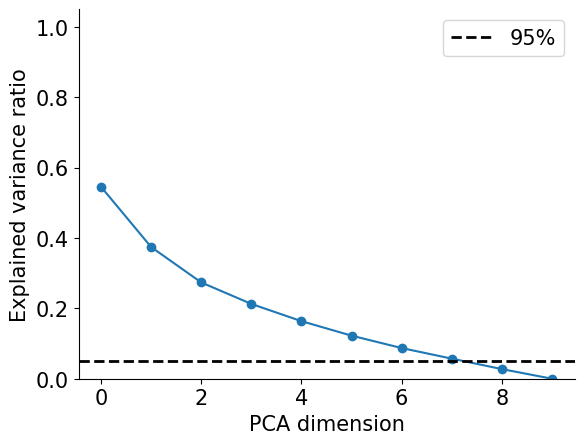

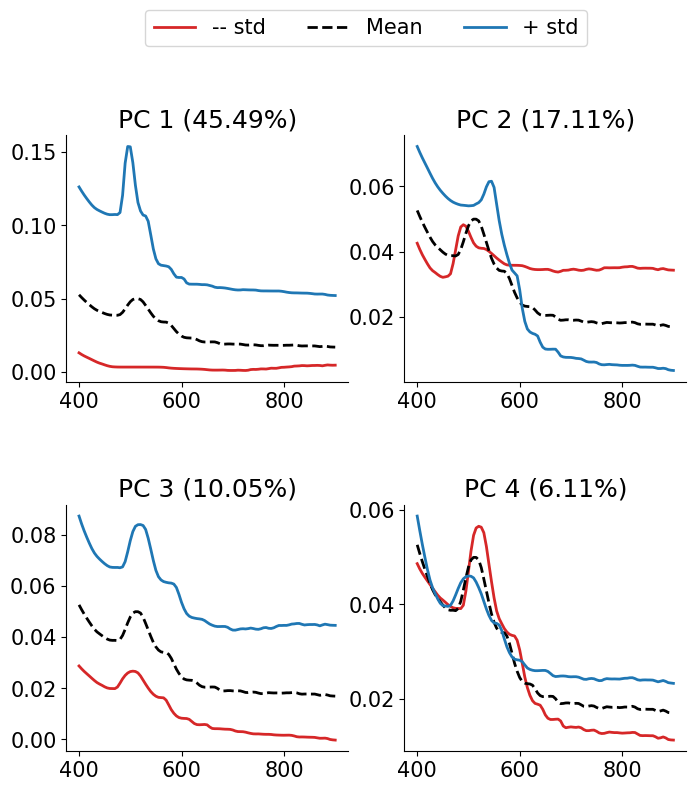

In [ ]:
def plot(jpca):

  # plot the explained variance
  cum_expr = 1-np.cumsum(jpca.latent) / sum(jpca.latent)
  expr = jpca.latent/ sum(jpca.latent)
  fig, ax = plt.subplots()
  ax.plot(np.arange(10), cum_expr, 'o-')
  ax.axhline(y=0.05, ls='--', lw=2.0, color='k', label=r'95%')
  ax.set_ylim([0,1.05])
  ax.set_xlabel('PCA dimension')
  ax.set_ylabel('Explained variance ratio')
  ax.legend()
  plt.show()

  # plot the component traversal
  fig, axs = plt.subplots(2,2, figsize=(4*2, 4*2))
  fig.subplots_adjust(wspace=0.2, hspace=0.5)
  axs = axs.flatten()
  for i, ax in enumerate(axs):
      # mean - std
      ax.plot(jpca.time, jpca.f_pca[:, 0, i], color='tab:red', lw=2.0)
      # mean
      ax.plot(jpca.time, jpca.f_pca[:, 1, i], color='k', ls='--', lw=2.0)
      # mean + std
      ax.plot(jpca.time, jpca.f_pca[:, 2, i], color='tab:blue', lw=2.0)
      ax.set_title(r'PC %d (%.2f'%(i+1, expr[i]*100)+r'%)')
  fig.legend(['-- std','Mean','+ std'],
              loc='upper center',
              ncol=3,
              bbox_to_anchor=(0.5,1.05))
  plt.savefig('jpca.png', dpi=600)

plot(jpca)